In [1]:
state = 'MT'
root_name = 'Missoula'   # which county will root our district?
k = 2                    # number of districts

In [2]:
# Function to read graph from json file
import json
from networkx.readwrite import json_graph

def read_graph_from_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return json_graph.adjacency_graph(data) 

In [3]:
# Read the county-level graph
filepath = 'C:\\districting-data-2020\\'
filename = state + '_county.json'

G = read_graph_from_json( filepath + filename )

for i in G.nodes:
    G.nodes[i]['TOTPOP'] = int( G.nodes[i]['P0010001'] )

In [4]:
import math

# Calculate lower and upper population limits
ideal_population = sum( G.nodes[i]['TOTPOP'] for i in G.nodes ) / k
L = math.floor( ideal_population )
U = math.ceil( ideal_population )
        
print("Using k =",k,"districts")
print("Lower population limit L =",L)
print("Upper population limit U =",U)

Using k = 2 districts
Lower population limit L = 542112
Upper population limit U = 542113


In [5]:
# Break symmetry by requiring a particular county be in the first district
for i in G.nodes:
    if G.nodes[i]['NAME20'] == root_name:
        root = i
        
print("Use",root_name,"County to root the first district. In our graph, this is vertex #",root)

Use Missoula County to root the first district. In our graph, this is vertex # 35


In [6]:
import networkx as nx

# Finds a minimal vertex subset that separates component from vertex b in digraph DG.
#
# This is algorithm 1 from Fischetti et al. 
#   "Thinning out Steiner trees: a node-based model for uniform edge costs." 
#   Mathematical Programming Computation 9.2 (2017): 203-229.
#
def find_minimal_separator(DG, component, b):
    neighbors_component = { i : False for i in DG.nodes }
    for i in nx.node_boundary(DG, component, None):
        neighbors_component[i] = True
    
    visited = { i : False for i in DG.nodes }
    child = [b]
    visited[b] = True
    
    while child:
        parent = child
        child = list()
        for i in parent:
            if not neighbors_component[i]:
                for j in DG.neighbors(i):
                    if not visited[j]:
                        child.append(j)
                        visited[j] = True
    
    C = [ i for i in DG.nodes if neighbors_component[i] and visited[i] ]
    return C

In [7]:
# Gurobi callback function, 
#   used to find/store the discovered districting plans 
#   or cut off infeasible (disconnected) solutions
def callback_function(m, where):

    # check if LP relaxation at this branch-and-bound node has an integer solution
    if where != GRB.Callback.MIPSOL: 
        return
        
    # retrieve the LP solution
    xval = m.cbGetSolution(m._x)
    k = m._k
    DG = m._DG
    root = m._root
    
    district = [ i for i in DG.nodes if xval[i,0] > 0.5 ]
    assert nx.is_strongly_connected( DG.subgraph(district) )
    
    # is complement connected? if so, we may be able to build a plan from this district
    complement = [ i for i in DG.nodes if xval[i,1] > 0.5 ]
    if len(complement)==1 or nx.is_strongly_connected( DG.subgraph(complement) ):
        m._districts.append( district )
        m._number_of_districts += 1
        #print("found district #", m._number_of_districts, ":", district)
        print("#", m._number_of_districts)
        
        # force at least one vertex from complement must move to first_district. 
        # (this is generally not valid, but with 1-person deviation it will only cut off 
        #   this particular solution as all counties have nontrivial population)
        m.cbLazy( gp.quicksum( m._x[i,0] for i in complement ) >= 1 )

        # hack to exit when enumeration_limit has been reached
        if m._number_of_districts == m._enumeration_limit:
            print("Enumeration limit has been reached. Exiting search.")
            m.cbLazy( m._x[root,1] >= 1 )
        
    # if second district is disconnected, then add a violated a,b-separator inequality
    else:
        assert k==2
        # find a maximum population component
        b = None
        max_component_population = -1
        for component in nx.strongly_connected_components( DG.subgraph(complement) ):
            component_population = sum( DG.nodes[i]['TOTPOP'] for i in component )
            if component_population > max_component_population:

                # find a maximum population vertex 'b' from this component
                max_component_population = component_population
                max_vertex_population = max( DG.nodes[i]['TOTPOP'] for i in component )
                max_population_vertices = [ i for i in component if DG.nodes[i]['TOTPOP'] == max_vertex_population ]
                b = max_population_vertices[0]

        # each other component (besides b's), find some vertex 'a' and add cut.
        for component in nx.strongly_connected_components( DG.subgraph(complement) ):
            if b in component:
                continue

            # find a maximum population vertex 'a' from this component
            max_vertex_population = max( DG.nodes[i]['TOTPOP'] for i in component )
            max_population_vertices = [ i for i in component if DG.nodes[i]['TOTPOP'] == max_vertex_population ]
            a = max_population_vertices[0]

            # add a,b-separator inequality
            C = find_minimal_separator(DG, component, b)
            m.cbLazy( m._x[a,1] + m._x[b,1] <= 1 + gp.quicksum( m._x[c,1] for c in C ) )

In [8]:
# Need a gurobi license to solve this model
import gurobipy as gp
from gurobipy import GRB

# build model
m = gp.Model()

# x[i,j]=1 if vertex i is assigned to district j
x = m.addVars(G.nodes, k, vtype=GRB.BINARY)

# each vertex is assigned to one district
m.addConstrs( x[i,0] + x[i,1] == 1 for i in G.nodes )

# add population balance constraints for district and its complement
m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,0] for i in G.nodes ) >= L )
m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,0] for i in G.nodes ) <= U )
m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,1] for i in G.nodes ) >= (k-1)*L )
m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,1] for i in G.nodes ) <= (k-1)*U )

# symmetry breaking: fix root to be in first district
x[root,0].LB = 1

M = G.number_of_nodes() - 1
DG = nx.DiGraph(G)

# add flow-based contiguity constraints (Shirabe) for first district
f = m.addVars(DG.edges)
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) == x[i,0] for i in G.nodes if i != root )
m.addConstrs( gp.quicksum( f[j,i] for j in G.neighbors(i) ) <= M * x[i,0] for i in G.nodes if i != root )
m.addConstr( gp.quicksum( f[j,root] for j in G.neighbors(root) ) == 0 )

# add compactness objective (to guide the search): a transportation objective for first district
dist = nx.shortest_path_length(G, source=root)
m.setObjective( gp.quicksum( dist[i] * dist[i] * math.ceil(G.nodes[i]['TOTPOP']/1000) * x[i,0] for i in G.nodes ), GRB.MINIMIZE )

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-11


In [9]:
# add cut-based contiguity constraints for second district (whose root we do not know a priori)
m.Params.LazyConstraints = 1
m._callback = callback_function

# additional bookkeeping 
m._x = x                    # assignment variables
m._k = k
m._L = L
m._U = U
m._DG = DG                  # directed graph
m._root = root              # root of the district
m._enumeration_limit = 10001# terminate the search after this many solutions have been found
m._districts = list()       # store districts here
m._number_of_districts = 0  # count the districts

# MIP tolerances
m.Params.IntFeasTol = 1e-7
m.Params.FeasibilityTol = 1e-7

# solve
m.optimize( m._callback )

Set parameter LazyConstraints to value 1
Set parameter IntFeasTol to value 1e-07
Set parameter FeasibilityTol to value 1e-07
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-4790 CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 171 rows, 388 columns and 1260 nonzeros
Model fingerprint: 0x9c6e796a
Variable types: 276 continuous, 112 integer (112 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+00, 6e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+05]
Presolve removed 59 rows and 64 columns
Presolve time: 0.01s
Presolved: 112 rows, 324 columns, 1019 nonzeros
Variable types: 269 continuous, 55 integer (55 binary)

Root relaxation: objective 1.444366e+03, 16 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  

In [10]:
def to_string(my_list):
    string = str()
    for i in my_list:
        string += str(i) + ","
    return string[:-1]   # remove last character (the comma)

def remove_duplicates(list_of_lists):
    input_len = len(list_of_lists)
    set_of_strings = { to_string(my_list) for my_list in list_of_lists }
    list_of_strings = [ string.split(',') for string in set_of_strings ]
    new_lol = [ [ int(i) for i in my_list ] for my_list in list_of_strings ]
    output_len = len(new_lol)
    print("Removed this many duplicates:", input_len - output_len )
    return new_lol

# remove any possible duplicates
m._districts = remove_duplicates(m._districts)

Removed this many duplicates: 0


In [11]:
# report solutions
print("We found the following",m._number_of_districts,"districts:\n")
for p in range(m._number_of_districts):
    print("district #",p+1,"is", m._districts[p],"\n")

We found the following 11 districts:

district # 1 is [0, 2, 3, 4, 8, 12, 19, 23, 26, 31, 35, 40, 41, 43, 46, 47, 53, 54, 55] 

district # 2 is [2, 3, 4, 8, 18, 22, 23, 26, 29, 31, 35, 41, 43, 45, 46, 47, 53, 54] 

district # 3 is [0, 2, 3, 8, 22, 23, 26, 31, 35, 40, 41, 43, 45, 46, 53, 54, 55] 

district # 4 is [2, 3, 8, 12, 13, 22, 23, 26, 28, 30, 31, 33, 35, 41, 45, 46, 47, 53, 54] 

district # 5 is [2, 3, 4, 8, 18, 22, 23, 26, 28, 30, 31, 35, 42, 43, 45, 46, 53, 54] 

district # 6 is [2, 3, 10, 12, 17, 19, 22, 23, 26, 30, 31, 33, 35, 41, 43, 46, 48, 51, 53, 54, 55] 

district # 7 is [2, 3, 8, 12, 22, 23, 26, 29, 30, 31, 33, 35, 40, 43, 46, 48, 53, 54, 55] 

district # 8 is [2, 3, 12, 19, 22, 23, 26, 29, 30, 31, 33, 35, 42, 46, 48, 53, 54, 55] 

district # 9 is [2, 3, 4, 8, 10, 18, 22, 23, 26, 30, 31, 33, 35, 41, 43, 44, 46, 48, 51, 53, 54] 

district # 10 is [0, 2, 3, 4, 8, 10, 13, 22, 23, 26, 28, 29, 31, 33, 35, 38, 39, 40, 43, 45, 46, 47, 48, 52, 54, 55] 

district # 11 is [0, 2,

In [12]:
import matplotlib.pyplot as plt
import geopandas as gpd

def draw_single_district( filepath, filename, G, district, zoom=False ):
    
    df = gpd.read_file( filepath + filename )
    node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }
    assignment = [ -1 for i in G.nodes ]

    if zoom:
        picked = { i : None for i in G.nodes }
    else:
        picked = { i : False for i in G.nodes }
    
    for i in district:
        picked[i] = True

    for u in range(G.number_of_nodes()):
        geoid = df['GEOID20'][u]
        i = node_with_this_geoid[geoid]
        assignment[u] = picked[i]

    df['assignment'] = assignment
    my_fig = df.plot(column='assignment').get_figure()
    return 

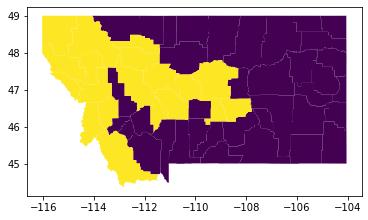

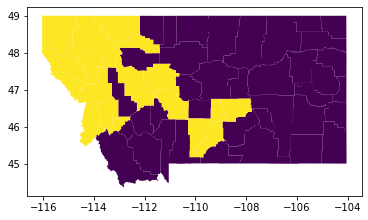

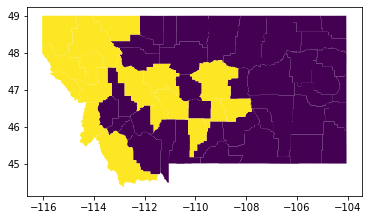

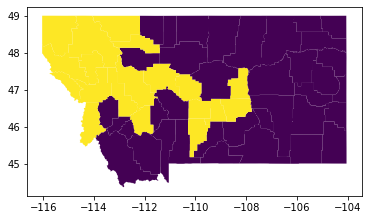

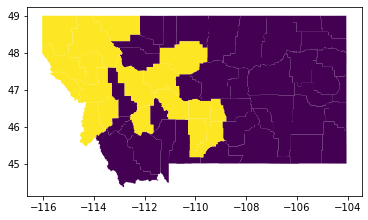

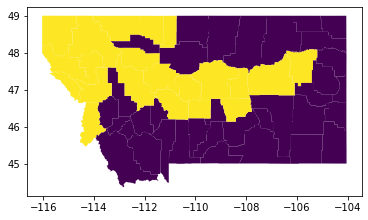

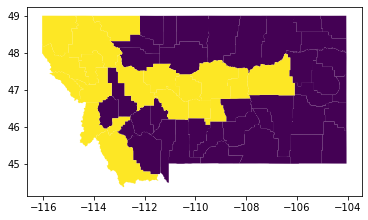

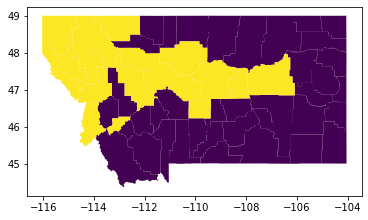

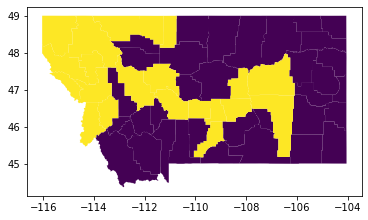

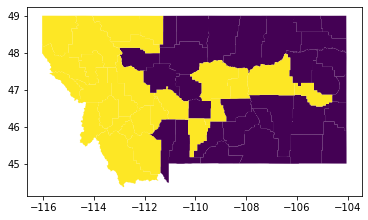

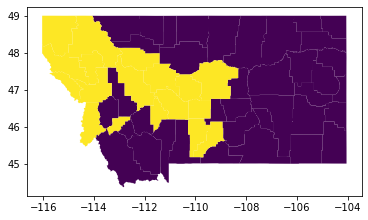

In [13]:
# Draw the districting plans.
# Limit of 20 images, due to large file size.

draw_limit = min( 20, m._number_of_districts )
filename = state + '_county.shp'

for p in range( draw_limit ):
    draw_single_district( filepath, filename, G, m._districts[p], zoom=False )
    #plt.figure()